In [1]:
from endo_ai.predictor.model_loader import MultiLabelClassificationNet
from pathlib import Path
from endo_ai.predictor.predict import Classifier
from endo_ai.predictor.inference_dataset import InferenceDataset
from endo_ai.predictor.predict import sample_config

FPS = 50
SMOOTH_WINDOW_SIZE_S = 1
MIN_SEQ_LEN_S = 0.5

model = MultiLabelClassificationNet.load_from_checkpoint("model/colo_segmentation_RegNetX800MF_6.ckpt")
_ = model.cuda()
_ = model.eval()
classifier = Classifier(model, verbose = True)

# get all filepaths from data folder
data_folder = Path("/home/agl-admin/endoreg-client-manager/endoreg_client_manager/data/tmp/raw_frames/65c9507b-f5b3-4626-83c7-ef56717d9cf4")
paths = [p for p in data_folder.glob('*.jpg')]
# frame names in format "frame_{index}.jpg"
indices = [int(p.stem.split("_")[1]) for p in paths]
path_index_tuples = list(zip(paths, indices))
# sort ascending by index
path_index_tuples.sort(key=lambda x: x[1])
paths, indices = zip(*path_index_tuples)

string_paths = [p.resolve().as_posix() for p in paths]

crops = [[0, 1080, 550, 1920-20] for _ in paths]

ds = InferenceDataset(
    string_paths,
    crops, config = sample_config
)

predictions = classifier.pipe(string_paths, crops)
readable_predictions = [classifier.readable(p) for p in predictions]


result = classifier.post_process_predictions(
    readable_predictions,
    window_size_s = SMOOTH_WINDOW_SIZE_S,
    min_seq_len_s = MIN_SEQ_LEN_S,
    fps = FPS,
)

for i, _dict in enumerate(result):
    _keys = list(_dict.keys())
    for key in _keys:
        # if numpy array
        if hasattr(_dict[key], "tolist"):
            result[i][key] = _dict[key].tolist()
        
        # check if list of tuples
        # if so, make sure each tuple has 2 elements and split to two lists (start, stop)
        if all(isinstance(x, tuple) for x in _dict[key]):
            if all(len(x) == 2 for x in _dict[key]):
                result[i][f"{key}_start"] = [int(x[0]) for x in _dict[key]]
                result[i][f"{key}_stop"] = [int(x[1]) for x in _dict[key]]
                
                # # set null if empty
                # if not result[i][f"{key}_start"]:
                #     result[i][f"{key}_start"] = None
                # if not result[i][f"{key}_stop"]:
                #     result[i][f"{key}_stop"] = None
                del result[i][key]
        

# predictions, smooth_predictions, binary_predictions, raw_sequences, filtered_sequences
predictions = result[0]
smooth_predictions = result[1]
binary_predictions = result[2]
raw_sequences = result[3]
filtered_sequences = result[4]

# save each file as json
import json
for i, _dict in enumerate(result):
    with open(f"results_{i}.json", "w") as f:
        json.dump(_dict, f, indent=4)



c:\Users\Thomas\miniconda3\envs\endo-frame-predictor\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Lightning automatically upgraded your loaded checkpoint from v1.5.9 to v2.0.8. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file c:\Users\Thomas\SynologyDrive\dev\agl-predict-endo-frame\model\colo_segmentation_RegNetX800MF_6.ckpt`
c:\Users\Thomas\miniconda3\envs\endo-frame-predictor\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Thomas\miniconda3\envs\endo-frame-predictor\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behav

In [15]:
target_directory = Path("data_anonym")

In [ ]:
import cv2
import os

def crop_and_save_images(image_paths, dimensions, output_dir):
    """
    Crop images based on the specified dimensions and save them in a different directory.
    
    Parameters:
        image_paths (list): List of file paths pointing to the images to be cropped.
        dimensions (list): List of tuples specifying the dimensions for cropping.
                          Each tuple is in the format (x, y, width, height).
        output_dir (str): Directory where the cropped images will be saved.
        
    Returns:
        None
    """
    image_paths = [_.as_posix() for _ in image_paths]
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Iterate through each image path and corresponding dimensions
    for image_path, dimension in zip(image_paths, dimensions):
        # Read the image
        img = cv2.imread(image_path)
        
        # If the image is not read properly, skip to the next image
        if img is None:
            print(f"Failed to read {image_path}. Skipping.")
            continue
        
        # Crop the image
        ymin, ymax, xmin, xmax = crop = dimension
        cropped_img = img[ymin:ymax, xmin:xmax, :]
        
        # Create the output file path
        base_name = os.path.basename(image_path)
        output_path = os.path.join(output_dir, f"cropped_{base_name}")
        
        # Save the cropped image
        cv2.imwrite(output_path, cropped_img)
        # print(f"Cropped image saved at {output_path}")

# Example usage
image_paths = paths
dimensions = [[0, 1080, 550, 1920-20] for _ in paths]
output_dir = target_directory.as_posix()

crop_and_save_images(image_paths, dimensions, output_dir)


In [6]:

# dataset = InferenceDataset(string_paths, )

In [9]:
len(paths)

957

In [3]:
# 1920 -> 1350 by removing the left 550 pixels and right 20 pixels
# crops is list of length len(paths) with each element being a numpy array of shape (ymin,,ymax,xmin,xmax)


In [7]:
predictions = classifier.pipe(string_paths, crops)
readable_predictions = [classifier.readable(p) for p in predictions]

fps = 50
# apply running mean to predictions (window size is 1 second)
import numpy as np
window_size = 1 * fps

merged_predictions = {key: [] for key in readable_predictions[0].keys()}
for p in readable_predictions:
    for key in p.keys():
        merged_predictions[key].append(p[key])

smooth_merged_predictions = {key: np.convolve(merged_predictions[key], np.ones(window_size)/window_size, mode='valid') for key in merged_predictions.keys()}







Dataset created
Dataloader created
Starting inference
First batch done


In [ ]:
binary_outside_predictions = np.array(smooth_outside_predictions) > 0.5

# get start and stop indices of all sequences with 1
starts = np.where(np.diff(binary_outside_predictions) < 0)[0]
stops = np.where(np.diff(binary_outside_predictions) > 0)[0]

# if the first prediction is 1, add a start at index 0
if binary_outside_predictions[0]:
    starts = np.concatenate([[0], starts])
# if the last prediction is 1, add a stop at the end
if binary_outside_predictions[-1]:
    stops = np.concatenate([stops, [len(binary_outside_predictions)]])

sequences = list(zip(starts, stops))

# remove sequences that are too short (less than 1 second)
min_duration = 1 * fps
sequences = [s for s in sequences if s[1] - s[0] > min_duration]

sequences




In [8]:
len(predictions)

957

In [11]:
predictions[0]

[0.02568245679140091,
 0.03210396692156792,
 0.016161613166332245,
 0.02195625565946102,
 0.013235650956630707,
 0.055444151163101196,
 0.08932320028543472,
 0.1805538833141327,
 0.020592568442225456,
 0.037484440952539444,
 0.23811590671539307,
 0.1550479531288147,
 0.013677037321031094,
 0.0164804607629776]

In [12]:
readable_predictions = [classifier.readable(p) for p in predictions]

In [13]:
readable_predictions[:2]

[{'appendix': 0.02568245679140091,
  'blood': 0.03210396692156792,
  'diverticule': 0.016161613166332245,
  'grasper': 0.02195625565946102,
  'ileocaecalvalve': 0.013235650956630707,
  'ileum': 0.055444151163101196,
  'low_quality': 0.08932320028543472,
  'nbi': 0.1805538833141327,
  'needle': 0.020592568442225456,
  'outside': 0.037484440952539444,
  'polyp': 0.23811590671539307,
  'snare': 0.1550479531288147,
  'water_jet': 0.013677037321031094,
  'wound': 0.0164804607629776},
 {'appendix': 0.026459526270627975,
  'blood': 0.03412337228655815,
  'diverticule': 0.016627714037895203,
  'grasper': 0.022903645411133766,
  'ileocaecalvalve': 0.013971230946481228,
  'ileum': 0.061707496643066406,
  'low_quality': 0.09504874795675278,
  'nbi': 0.18197108805179596,
  'needle': 0.021035058423876762,
  'outside': 0.03767135366797447,
  'polyp': 0.22808830440044403,
  'snare': 0.1525668352842331,
  'water_jet': 0.014157935045659542,
  'wound': 0.017148012295365334}]

In [ ]:

import json

json_dict = {
    "labels": classifier.config["labels"],
    "paths": string_paths,
    "predictions": predictions
}

with open("predictions.json", "w") as f:
    json.dump(json_dict, f)

: 

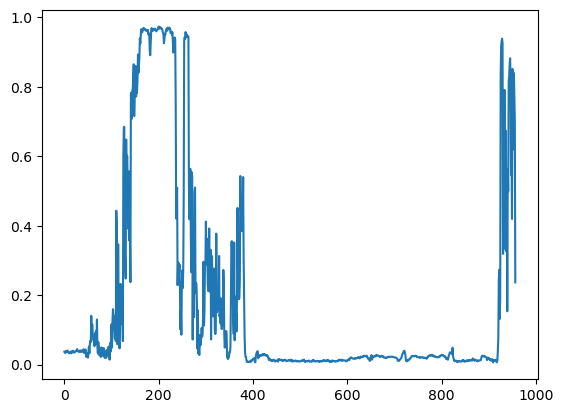

In [18]:
# make a json file for the predictions
# {
# "labels": array of strings corresponding to the labels for each prediction array
# "paths": array of string paths,
# "predictions": holds array of predictions for each path
# }



